In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
!git clone https://github.com/mpatacchiola/pyERA.git
!python pyERA/setup.py install
!mkdir results

fatal: destination path 'pyERA' already exists and is not an empty directory.


running install
running build
running build_py
running install_lib
running install_egg_info
Removing C:\Users\rodri\Anaconda3\Lib\site-packages\pyERA-0.1-py3.7.egg-info
Writing C:\Users\rodri\Anaconda3\Lib\site-packages\pyERA-0.1-py3.7.egg-info


C:\Users\rodri\Anaconda3\lib\distutils\dist.py:274: UserWarning: Unknown distribution option: 'include_package_data'
  warnings.warn(msg)
file pyERA.py (for module pyERA) not found
package init file 'pyERA\__init__.py' not found (or not a regular file)
file pyERA.py (for module pyERA) not found
package init file 'pyERA\__init__.py' not found (or not a regular file)
J  existe uma subpasta ou um arquivo results.


# Treinamento da rede

In [3]:
from pyERA.pyERA.som import Som
from pyERA.pyERA.utils import ExponentialDecay
from scipy import ndimage

def create_image(image_path):

    # setup
    SAVE_IMAGE = True
    output_path = "results/"
    
    # abrindo a imagem e convertendo para cinza
    img_size = 172
    img_original = plt.imread(image_path)
    img_rsz = cv2.resize(img_original, (img_size, img_size))
    image = plt.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(gray, (img_size, img_size))
    img_matrix = np.asarray(img, dtype=np.float32)
    plt.imshow(image)
    plt.show()
    #Normalização de pixeis values to sum up to 1.0
    img_prob = (255.0 - img_matrix) / 255.0
    img_prob = img_prob / np.sum(img_prob, dtype=np.float32)

    #criando uma lista unidimensional de elementos
    index_list = list()
    for row in range(0,img_size):
        for col in range(0,img_size):
            index_list.append(np.array([row,col]))
            
    single_index_array = np.arange(0, img_size*img_size)

    # hiperparâmetros da SOM
    som_size = 128
    batch_size = 64
    my_som = Som(matrix_size=som_size, input_size=2, low=0, high=img_size-1, round_values=True)
    tot_epochs = 50
    my_learning_rate = ExponentialDecay(starter_value=0.9, decay_step=50, decay_rate=0.9, staircase=True)
    my_radius = ExponentialDecay(starter_value=np.rint(som_size/5), decay_step=80, decay_rate=0.95, staircase=True)

    for epoch in range(0, tot_epochs):

        # iniciando a partir de uma lista aleatóriamente escolhida com a probabilidade da lista unidimensional
        input_vector_list = list()
        sorted_index_list = np.random.choice(single_index_array, batch_size, p=img_prob.flatten())
        for i in range(0, batch_size): 
            input_vector_list.append(index_list[sorted_index_list[i]])

        #atualizando a taxa de aprendizagem e raio
        learning_rate = my_learning_rate.return_decayed_value(global_step=epoch)
        radius = my_radius.return_decayed_value(global_step=epoch)
        
        if(epoch % 1 == 0):
            #Gerando a imagem a partir do SOM
            som_img = np.full((img_size, img_size, 3), 255, dtype=np.uint8)
            som_weights_matrix = my_som.return_weights_matrix()
            for row in range(0, som_weights_matrix.shape[0]):
                for col in range(0, som_weights_matrix.shape[1]):
                    x = int(som_weights_matrix[row, col, 0])
                    y = int(som_weights_matrix[row, col, 1])
                    som_img[x, y, 0] = 0
                    som_img[x, y, 1] = 0
                    som_img[x, y, 2] = 0

            if(SAVE_IMAGE == True):
                fig = plt.figure()
                a=fig.add_subplot(1,2,1)
                imgplot = plt.imshow(ndimage.rotate(img_original, 0))
                plt.axis("off")
                b=fig.add_subplot(1,2,2)

                imgplot = plt.imshow(som_img)
                #plt.show()
                plt.axis("off")
                plt.savefig(output_path + str(epoch) + ".png", dpi=200, facecolor='black')
                plt.close('all')
                print("epoch", str(epoch))

        my_som.training_batch_step(input_vector_list, learning_rate=learning_rate, radius=radius, weighted_distance=True)


    file_name = "result/final.npz"
    print("Saving the network in: " + str(file_name))
    my_som.save(path="results/", name="model")
    


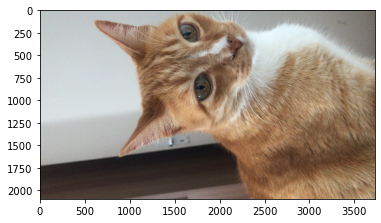

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
Saving the network in: result/final.npz


In [5]:
create_image('kleber/1.jpg')

# Teste com outras imagens

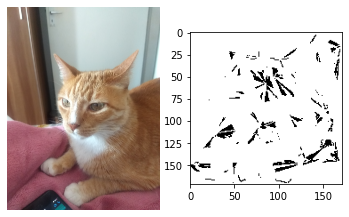

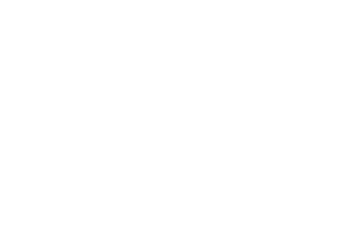

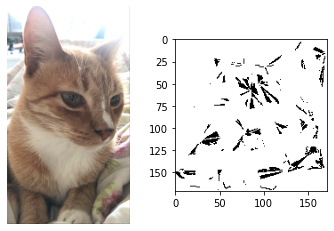

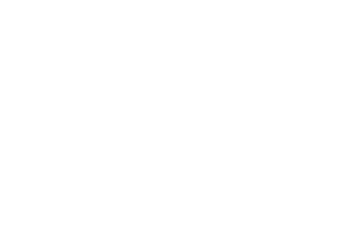

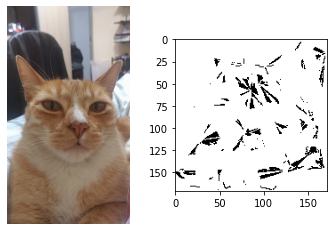

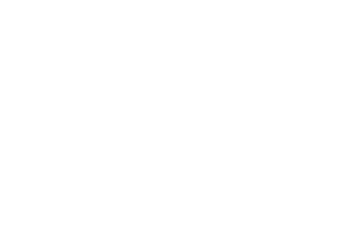

In [6]:
s = Som(128, input_size=2)
s.load('results/model.npz')

for i in os.listdir('kleber'):
    img_original = plt.imread('kleber/'+i)
    som_img = np.full((172, 172, 3), 255, dtype=np.uint8)
    som_weights_matrix = s.return_weights_matrix()
    for row in range(0, som_weights_matrix.shape[0]):
        for col in range(0, som_weights_matrix.shape[1]):
            x = int(som_weights_matrix[row, col, 0])
            y = int(som_weights_matrix[row, col, 1])
            som_img[x, y, 0] = 0
            som_img[x, y, 1] = 0
            som_img[x, y, 2] = 0


    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(ndimage.rotate(img_original, 0))
    plt.axis("off")
    b=fig.add_subplot(1,2,2)

    imgplot = plt.imshow(som_img)
    plt.show()
    plt.axis("off")
